# Predicting Bike Rentals Using Machine Learning
The aim of this analysis is to build machine learning models to predict the number of bikes rented through a cycle hire scheme, in a given hour, and to compare the accuracy of ddifferent kinds of models.

Hadi Fanaee-T at the University of Porto compiled data on the use of the Washington D.C. cycle hire scheme into a CSV file. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. The data can be downloaded from the University of California, Irvine's _[website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)_.

## Aims
This analysis will compare the accuracy of linear regression, decision tree and random forest models. Furthermore, it will compare the accuracy of each kind of model when using three different kinds of encoding for categorical values: no encoding (allowing scikit-learn to interpret the numbers in the categorical columns as ordinal), one-hot encoding and binary encoding.

### Setup and initial data exploration

In [1327]:
# Import libraries as required
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [1328]:
# Read in data and check first few rows
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


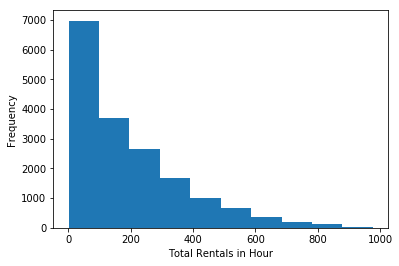

In [1329]:
# Visualise distribution of "cnt" column
plt.hist(bike_rentals["cnt"])
plt.xlabel('Total Rentals in Hour')
plt.ylabel('Frequency')
plt.show()

In [1330]:
# Calculate correlation coefficients between each column and "cnt"
cnt_corr = bike_rentals.corr()["cnt"].sort_values(ascending=False)
cnt_corr

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

#### Non-applicable Correlations
It is important to note that not all of the above correlation coefficients are useful for model-building purposes. The `registered` and `casual` variables are the component parts of `cnt` (the number of registered and non-registered users of the bikes) and therefore leak information about the outcome.

## Cleaning and munging data

### Creating dummy variables for non-ordinal columns
#### Create dummy variables using one-hot encoding

In [1331]:
# Check number of unique categories for each categorical column is manageable
category_cols = ["season", "mnth", "hr", "weekday", "weathersit"]

for col in category_cols:
    print(col + ": " + str(bike_rentals[col].unique()))

season: [1 2 3 4]
mnth: [ 1  2  3  4  5  6  7  8  9 10 11 12]
hr: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
weekday: [6 0 1 2 3 4 5]
weathersit: [1 2 3 4]


In [1332]:
# Convert columns to category data types
for cat_col in category_cols:
    bike_rentals[cat_col] = bike_rentals[cat_col].astype('category')
bike_rentals.dtypes

instant          int64
dteday          object
season        category
yr               int64
mnth          category
hr            category
holiday          int64
weekday       category
workingday       int64
weathersit    category
temp           float64
atemp          float64
hum            float64
windspeed      float64
casual           int64
registered       int64
cnt              int64
dtype: object

In [1333]:
# Generate dummy columns
oh_dummies = pd.get_dummies(bike_rentals[category_cols])
oh_dummy_cols = oh_dummies.columns
oh_dummies.head()

,season_1,season_2,season_3,season_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [1334]:
# Add dummy columns to bike_rentals
bike_rentals = pd.concat([bike_rentals, oh_dummies], axis=1)
bike_rentals.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'season_1', 'season_2', 'season_3',
       'season_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6',
       'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'hr_0',
       'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9',
       'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17',
       'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weathersit_1', 'weathersit_2', 'weathersit_3',
       'weathersit_4'],
      dtype='object')

#### Create dummy variables using binary encoding

In [1335]:
bin_dummies = pd.DataFrame()

for col in category_cols:
    bin_dummies[col] = bike_rentals[col].cat.codes.apply(lambda x: list(str(bin(x)[2:]).zfill(7)))
    for i in range(0,7):
        column_title = str(col) + "_bin_" + str(i)
        bin_dummies[column_title] = bin_dummies[col].apply(lambda x: int(x[i]))
        
bin_dummies = bin_dummies.drop(category_cols, axis=1)

for col in category_cols:
    for i in range(0,7):
        col_name = str(col)+"_bin_"+str(i)
        if bin_dummies[col_name].sum() == 0:
            bin_dummies = bin_dummies.drop(col_name, axis=1)
        else:
            break

bin_dummy_cols = bin_dummies.columns
bin_dummies.head()

,season_bin_5,season_bin_6,mnth_bin_3,mnth_bin_4,mnth_bin_5,mnth_bin_6,hr_bin_2,hr_bin_3,hr_bin_4,hr_bin_5,hr_bin_6,weekday_bin_4,weekday_bin_5,weekday_bin_6,weathersit_bin_5,weathersit_bin_6
0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0
3,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0


In [1336]:
# Add dummy columns to bike_rentals
bike_rentals = pd.concat([bike_rentals, bin_dummies], axis=1)
bike_rentals.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'season_1', 'season_2', 'season_3',
       'season_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6',
       'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'hr_0',
       'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9',
       'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17',
       'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weathersit_1', 'weathersit_2', 'weathersit_3',
       'weathersit_4', 'season_bin_5', 'season_bin_6', 'mnth_bin_3',
       'mnth_bin_4', 'mnth_bin_5', 'mnth_bin_6', 'hr_bin_2', 'hr_bin_3',
       'hr_bin_4', 'hr_bin_5', 'hr_bin_6', 'weekday_bin_4', 'weekday_bin_5',
       'weekday_bin_6', 'w

In [1337]:
# Convert category columns back to integers for later testing
for cat_col in category_cols:
    bike_rentals[cat_col] = bike_rentals[cat_col].astype('int')

#### Check to see if `instant` is always just one more than the row index. If so, it can be dropped.

In [1338]:
not_plus_one = 0
for ind, row in bike_rentals.iterrows():
    if row["instant"] != (ind+1):
        not_plus_one += 1
not_plus_one

0

All values of `instant` are simply one greater than the index. As such, this column provides no new information and can be dropped leaving us with a final dataset to use for modelling.

In [1339]:
bike_rentals = bike_rentals.drop("instant", axis=1)
bike_rentals.columns

Index(['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'season_1', 'season_2', 'season_3',
       'season_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6',
       'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'hr_0',
       'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9',
       'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17',
       'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weathersit_1', 'weathersit_2', 'weathersit_3',
       'weathersit_4', 'season_bin_5', 'season_bin_6', 'mnth_bin_3',
       'mnth_bin_4', 'mnth_bin_5', 'mnth_bin_6', 'hr_bin_2', 'hr_bin_3',
       'hr_bin_4', 'hr_bin_5', 'hr_bin_6', 'weekday_bin_4', 'weekday_bin_5',
       'weekday_bin_6', 'weathersit_b

In [1340]:
# Final check for null_values
bike_rentals.isnull().sum()

dteday              0
season              0
yr                  0
mnth                0
hr                  0
holiday             0
weekday             0
workingday          0
weathersit          0
temp                0
atemp               0
hum                 0
windspeed           0
casual              0
registered          0
cnt                 0
season_1            0
season_2            0
season_3            0
season_4            0
mnth_1              0
mnth_2              0
mnth_3              0
mnth_4              0
mnth_5              0
mnth_6              0
mnth_7              0
mnth_8              0
mnth_9              0
mnth_10             0
                   ..
hr_21               0
hr_22               0
hr_23               0
weekday_0           0
weekday_1           0
weekday_2           0
weekday_3           0
weekday_4           0
weekday_5           0
weekday_6           0
weathersit_1        0
weathersit_2        0
weathersit_3        0
weathersit_4        0
season_bin

## Preparing for modelling
### Choosing error metrics
Now that the categorical columns have been correctly formatted, correlation coefficients between each columns and "cnt" will be calculated. A cross-correlation heatmap will also be plotted to look for multicollinearity that could prove problematic.

In [1341]:
corr_grid = bike_rentals.drop(["registered", "casual"], axis=1).corr()
corr_cnt = corr_grid["cnt"].abs().sort_values(ascending=False).drop("cnt")
corr_cnt

temp                0.404772
atemp               0.400929
hr                  0.394071
hum                 0.322911
hr_17               0.313996
hr_bin_2            0.300042
hr_18               0.272114
yr                  0.250495
season_1            0.245456
hr_bin_3            0.217022
hr_4                0.206352
hr_3                0.200296
hr_8                0.195313
hr_5                0.193936
hr_2                0.190250
hr_1                0.179420
season              0.178056
mnth_bin_4          0.172934
season_bin_5        0.158053
mnth_1              0.156834
hr_0                0.156054
hr_bin_4            0.153115
season_3            0.151621
weathersit          0.142426
hr_16               0.141443
hr_19               0.140710
hr_6                0.130467
weathersit_bin_5    0.128311
weathersit_3        0.128034
mnth_2              0.122113
                      ...   
hr_bin_5            0.050589
weathersit_bin_6    0.047141
weathersit_2        0.046902
hr_20         

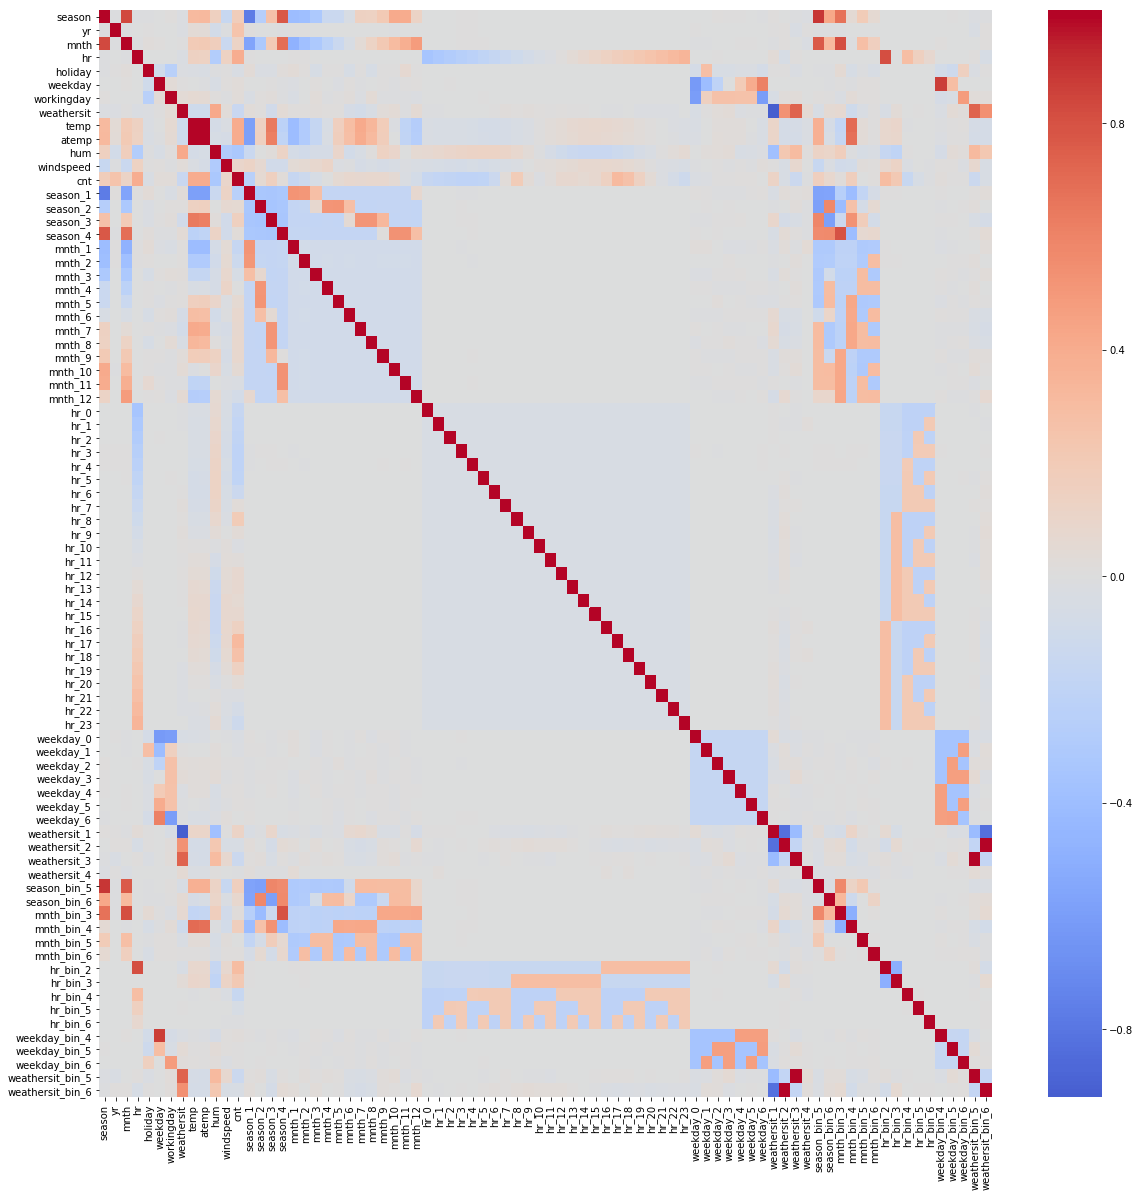

In [1342]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_grid, center=0, cmap="coolwarm")

#### Notes on multicollinearity
There are signs of multicollinearity between a number of variables.

The month and season columns are, of course correlated. The season columns are also quite strongly correlated with the temperature-based variables.The temperature (`temp`) and adjusted temperature (`atemp`) variables, are also highly correlated. It is clear that weekdays 0 and 6 signify weekends due to a strong negative correlation between these days and `workingday`.

### Creating feature sets
A variety of feature sets will be created to test the model accuracy when using different types of encoding for categorical variables.

 - `features_ord` uses the original ordinal categories (against best practice for scikit-learn).
 - `features_oh` uses one-hot encoded categories.
 - `features_bin` uses binary encoded categories.

In [1343]:
collin_cols_ord = ([
    "season",
    "workingday"
])

collin_cols_oh = ([
    "season_1",
    "season_2",
    "season_3",
    "season_4",
    "workingday"
])

collin_cols_bin = ([
    "season_bin_5",
    "season_bin_6"
])

features_all = bike_rentals.columns
# Drop columns that don't apply or leak info about outcome
features_all = features_all.drop(["dteday","casual", "registered", "cnt", "atemp"])

# Create feature set using original ordinal categories
features_ord = features_all.drop(oh_dummy_cols)
features_ord = features_ord.drop(bin_dummy_cols)

# Create feature set using one-hot encoded categories
features_oh = features_all.drop(category_cols)
features_oh = features_oh.drop(bin_dummy_cols)

# Create feature set using binary encoded categories
features_bin = features_all.drop(category_cols)
features_bin = features_bin.drop(oh_dummy_cols)

# Create feature sets with multicoliinearity removed
features_ord_nocollin = features_ord.drop(collin_cols_ord)
features_oh_nocollin = features_oh.drop(collin_cols_oh)
features_bin_nocollin = features_bin.drop(collin_cols_bin)

print(features_ord)
print(features_ord_nocollin)

print(features_oh)
print(features_oh_nocollin)

print(features_bin)
print(features_bin_nocollin)

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'hum', 'windspeed'],
      dtype='object')
Index(['yr', 'mnth', 'hr', 'holiday', 'weekday', 'weathersit', 'temp', 'hum',
       'windspeed'],
      dtype='object')
Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_1',
       'season_2', 'season_3', 'season_4', 'mnth_1', 'mnth_2', 'mnth_3',
       'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10',
       'mnth_11', 'mnth_12', 'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5',
       'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13',
       'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21',
       'hr_22', 'hr_23', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_1', 'weathersit_2',
       'weathersit_3', 'weathersit_4'],
      dtype='object')
Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'mnth

### Selecting an error metric
A number of different models will be built (linear regression, decision tree and random forest). Each will be tested for accuracy using the mean squared error (MSE) metric.

### Creating training and testing datasets
A randomly selected 80% of the data will form a training dataset. The remaining data will be used for testing of model accuracy.

In [1344]:
train = bike_rentals.sample(frac=0.8, random_state=1).copy()
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)].copy()
print(train.shape, test.shape)

(13903, 83) (3476, 83)


## Linear regression model
#### Using raw category codes (not encoded)
Without colinear columns removed:

In [1345]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lrm = LinearRegression()
lrm.fit(train[features_ord], train["cnt"])

predictions_lin = lrm.predict(test[features_ord])

mse_lin_ord = mean_squared_error(test["cnt"], predictions_lin)
mse_lin_ord

19620.90466557975

With colinear columns removed:

In [1346]:
lrm = LinearRegression()
lrm.fit(train[features_ord_nocollin], train["cnt"])

predictions_lin = lrm.predict(test[features_ord_nocollin])

mse_lin_ord_nocollin = mean_squared_error(test["cnt"], predictions_lin)
mse_lin_ord_nocollin

19736.943751339095

#### Using one-hot encoded categories
Without colinear columns removed:

In [1347]:
# Use one-hot encoded categories
lrm = LinearRegression()
lrm.fit(train[features_oh], train["cnt"])

predictions_lin = lrm.predict(test[features_oh])

mse_lin_oh = mean_squared_error(test["cnt"], predictions_lin)
mse_lin_oh

10545.821953214901

With colinear columns removed:

In [1348]:
lrm = LinearRegression()
lrm.fit(train[features_oh_nocollin], train["cnt"])

predictions_lin = lrm.predict(test[features_oh_nocollin])

mse_lin_oh_nocollin = mean_squared_error(test["cnt"], predictions_lin)
mse_lin_oh_nocollin

10694.811440251638

#### Using binary encoded categories
Without colinear columns removed:

In [1349]:
lrm = LinearRegression()
lrm.fit(train[features_bin], train["cnt"])

predictions_lin = lrm.predict(test[features_bin])

mse_lin_bin = mean_squared_error(test["cnt"], predictions_lin)
mse_lin_bin

16340.169537882377

With colinear columns removed:

In [1350]:
lrm = LinearRegression()
lrm.fit(train[features_bin_nocollin], train["cnt"])

predictions_lin = lrm.predict(test[features_bin_nocollin])

mse_lin_bin_nocollin = mean_squared_error(test["cnt"], predictions_lin)
mse_lin_bin_nocollin

16644.728323991796

#### Conclusions - linear model
The linear model that provided the most accurate predictions is that using one-hot encoding for the categorical variables. The worst performing model is that using the raw column numbers and allowing the algorithm to interpret them as ordinal values. Notably, removing columns that showed signs of colinearity slightly reduced the accuracy of the models. As such, these columns will be re-introduced going forward.

The mean squared error (MSE) values for each of the models (including all features) are shown below. Lower values indicate more accurate predictions:

In [1351]:
lin_mses = pd.Series([mse_lin_ord, mse_lin_oh, mse_lin_bin], index=['raw_categories', 'one_hot', 'binary'])
lin_mses

raw_categories    19620.904666
one_hot           10545.821953
binary            16340.169538
dtype: float64

## Decision Tree Model

In [1352]:
from sklearn.tree import DecisionTreeRegressor

# Let minimum samples in a leaf = 1
dtrm = DecisionTreeRegressor(min_samples_leaf=1)

dtrm.fit(train[features_ord], train["cnt"])
predictions_dt = dtrm.predict(test[features_ord])

mse = mean_squared_error(test["cnt"], predictions_dt)
mse

3646.888665132336

In [1353]:
# Let minimum samples in a leaf = 1
dtrm = DecisionTreeRegressor(min_samples_leaf=1)

dtrm.fit(train[features_oh], train["cnt"])
predictions_dt = dtrm.predict(test[features_oh])

mse = mean_squared_error(test["cnt"], predictions_dt)
mse

4644.3041570771

In [1354]:
# Let minimum samples in a leaf = 1
dtrm = DecisionTreeRegressor(min_samples_leaf=1)

dtrm.fit(train[features_bin], train["cnt"])
predictions_dt = dtrm.predict(test[features_bin])

mse = mean_squared_error(test["cnt"], predictions_dt)
mse

4667.550417146145

In [1355]:
# Vary minimum samples in a leaf
mse_values = pd.Series(index=range(1,21))
for i in range(1,21):
    dtrm = DecisionTreeRegressor(min_samples_leaf=i)

    dtrm.fit(train[features_ord], train["cnt"])
    predictions_dt = dtrm.predict(test[features_ord])

    mse = mean_squared_error(test["cnt"], predictions_dt)
    mse_values[i] = mse

best_mse = mse_values[mse_values==mse_values.min()]
mse_dt_ord = int(best_mse)
best_mse

6    2870.819048
dtype: float64

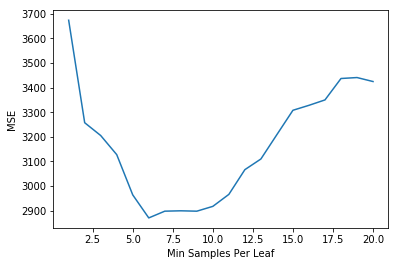

In [1356]:
plt.plot(mse_values.index, mse_values)
plt.xlabel('Min Samples Per Leaf')
plt.ylabel('MSE')
plt.show()

In [1357]:
# Vary minimum samples in a leaf
mse_values = pd.Series(index=range(1,21))
for i in range(1,21):
    dtrm = DecisionTreeRegressor(min_samples_leaf=i)

    dtrm.fit(train[features_oh], train["cnt"])
    predictions_dt = dtrm.predict(test[features_oh])

    mse = mean_squared_error(test["cnt"], predictions_dt)
    mse_values[i] = mse

best_mse = mse_values[mse_values==mse_values.min()]
mse_dt_oh = int(best_mse)
best_mse

4    3883.289755
dtype: float64

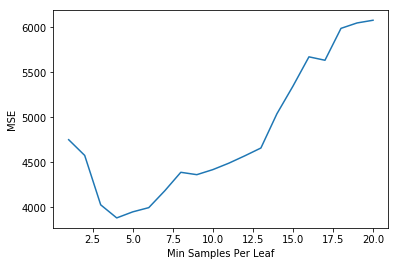

In [1358]:
plt.plot(mse_values.index, mse_values)
plt.xlabel('Min Samples Per Leaf')
plt.ylabel('MSE')
plt.show()

In [1359]:
# Vary minimum samples in a leaf
mse_values = pd.Series(index=range(1,21))
for i in range(1,21):
    dtrm = DecisionTreeRegressor(min_samples_leaf=i)

    dtrm.fit(train[features_bin], train["cnt"])
    predictions_dt = dtrm.predict(test[features_bin])

    mse = mean_squared_error(test["cnt"], predictions_dt)
    mse_values[i] = mse

best_mse = mse_values[mse_values==mse_values.min()]
mse_dt_bin = int(best_mse)
best_mse

6    3536.159976
dtype: float64

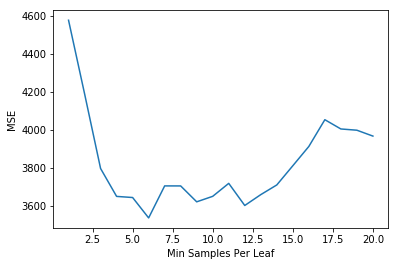

In [1360]:
plt.plot(mse_values.index, mse_values)
plt.xlabel('Min Samples Per Leaf')
plt.ylabel('MSE')
plt.show()

#### Conclusions - decision tree model
All of the decision tree models gave higher prediction accuracy than the linear regression models.

The decision tree model with the highest accuracy is that which uses the raw column codes. This may imply that, despite scikit learn's implementation of the CART algorithm assuming ordinality, such an assumption did not negatively effect the prediction accuracy. The model using binary encoding for the categorical variables was next most accurate, with the model using one-hot encoding for the categorical variables giving the least accurate predictions.

For each kind of encoding, the prediction accuracy was improved by limiting the minimum number of samples per leaf and thereby reducing overfitting. The highest accuracy was achieved with a minimum number of samples per leaf of 6 for the models using the raw category codes and binary encoding, and 4 for the model using one-hot encoding. The MSE results for these models are shown below:

In [1361]:
dt_mses = pd.Series([mse_dt_ord, mse_dt_oh, mse_dt_bin], index=['raw_categories', 'one_hot', 'binary'])
dt_mses

raw_categories    2870
one_hot           3883
binary            3536
dtype: int64

## Random Forest Model

In [1362]:
from sklearn.ensemble import RandomForestRegressor

# Let minimum samples in a leaf = 1
rfrm = RandomForestRegressor(min_samples_leaf=1)

rfrm.fit(train[features_ord], train["cnt"])
predictions_rf_ord = rfrm.predict(test[features_ord])

mse_rf_ord = mean_squared_error(test["cnt"], predictions_rf_ord)
mse_rf_ord

2120.120105685015

In [1363]:
# Let minimum samples in a leaf = 1
rfrm = RandomForestRegressor(min_samples_leaf=1)

rfrm.fit(train[features_oh], train["cnt"])
predictions_rf = rfrm.predict(test[features_oh])

mse_rf_oh = mean_squared_error(test["cnt"], predictions_rf)
mse_rf_oh

2850.9280793065145

In [1364]:
# Let minimum samples in a leaf = 1
rfrm = RandomForestRegressor(min_samples_leaf=1)

rfrm.fit(train[features_bin], train["cnt"])
predictions_rf = rfrm.predict(test[features_bin])

mse_rf_bin = mean_squared_error(test["cnt"], predictions_rf)
mse_rf_bin

2694.924671317606

#### Varying minimum samples per leaf for Random Forest model

In [1365]:
mse_values = pd.Series(index=range(1,21))
for i in range(1,21):
    rfrm = RandomForestRegressor(min_samples_leaf=i)

    rfrm.fit(train[features_ord], train["cnt"])
    predictions_rf = rfrm.predict(test[features_ord])

    mse = mean_squared_error(test["cnt"], predictions_rf)
    mse_values[i] = mse

mse_values

1     2085.992894
2     2221.706934
3     2192.047559
4     2204.142003
5     2309.315178
6     2380.829665
7     2372.638262
8     2523.831720
9     2412.961482
10    2731.612812
11    2633.377611
12    2730.590086
13    2760.249565
14    2919.993232
15    2947.927082
16    3030.353331
17    3059.291759
18    3038.476712
19    3209.054682
20    3054.508492
dtype: float64

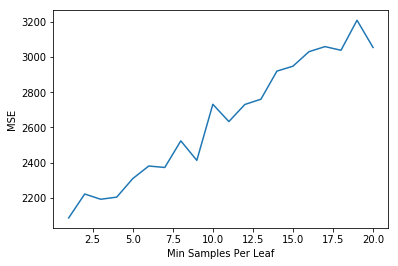

In [1366]:
plt.plot(mse_values.index, mse_values)
plt.xlabel('Min Samples Per Leaf')
plt.ylabel('MSE')
plt.show()

Unlike with the single decision tree models, the above graph shows that increasing the minimum number of samples per leaf has little to no beneficial impact on the accuracy of the random forest model. This is because the ensembling inherent to random forests already reduces overfitting, so pruning the trees by increasing the minimum samples per leaf is not required.

The above shows that the model accuracy increases rapidly with increasing tree depth until the tree is approximately 15 levels deep, after which there is no further gain in accuracy with increasing depth.

## Conclusions
The random forest models provide more accurate predictions than the linear regression models or decision tree models.

Regarding encoding of categorical variables, the most accurate model is that which simply uses the raw category numbers, despite this leading the algorithm to assume ordinality where none is present (e.g. Wednesday is greater than Monday). Binary encoding performs slighty better than one-hot encoding. It is likely that this difference would widen if each of the categories had more unique values, due to the greater increase in dimensionality associated with one-hot encoding.

Note that, while increasing the minimum number of samples per leaf improved the accuracy of the decision tree model, this is not the case with the random forest model. The improvement seen in the decision tree model was due to the reduction of overfitting. The random forest model reduces ovefitting by averaging the results from several decision trees, thereby reducing the impact of overfitting by any one model. As such, increasing the minimum samples per leaf is not required for the random forests model as ensembling has already accounted for possible overfitting.

The MSE values for the best performing random forest models from each encoding system can be seen below:

In [1367]:
rf_mses = pd.Series([mse_rf_ord, mse_rf_oh, mse_rf_bin], index=['raw_categories', 'one_hot', 'binary'])
rf_mses

raw_categories    2120.120106
one_hot           2850.928079
binary            2694.924671
dtype: float64

## Accuracy of Best Model
The below graphs provide a visual representation of the accuracy of predictions made by the best model found; the random forest model using the raw categorical column labels:

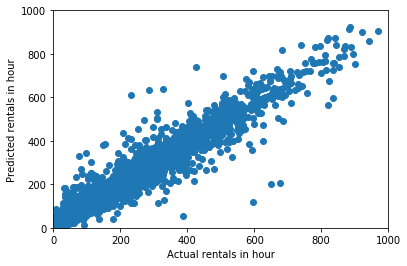

In [1368]:
plt.scatter(test["cnt"], predictions_rf_ord)
plt.xlim((0,1000))
plt.ylim((0,1000))
plt.xlabel('Actual rentals in hour')
plt.ylabel('Predicted rentals in hour')
plt.show()

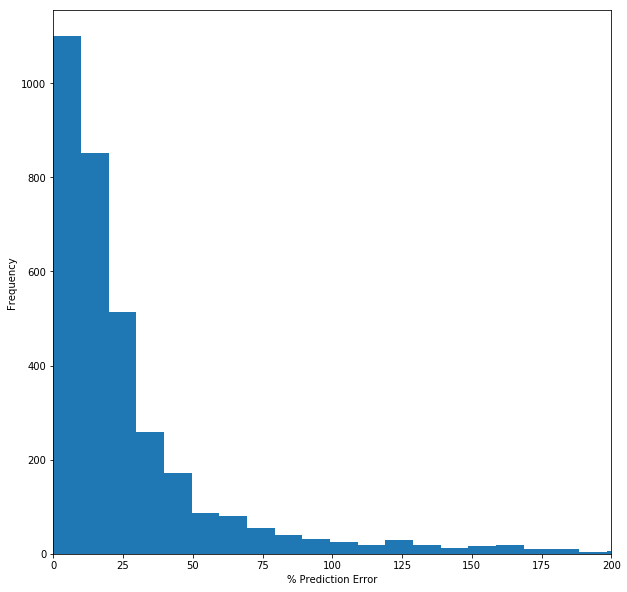

In [1369]:
abs_pc_error = np.abs(((test["cnt"] - predictions_rf) / test["cnt"])*100)

plt.figure(figsize=(10,10))
plt.hist(abs_pc_error, bins=1000)
plt.xlabel("% Prediction Error")
plt.xlim((0, 200))
plt.ylabel("Frequency")
plt.show()